# python-mip Battery Optimisation

In [1]:
from pathlib import Path
from datetime import timedelta
import timeit

from mip import *
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%load_ext jupyter_black

## NSW Energy Price Dec 2021

<AxesSubplot: xlabel='datetime'>

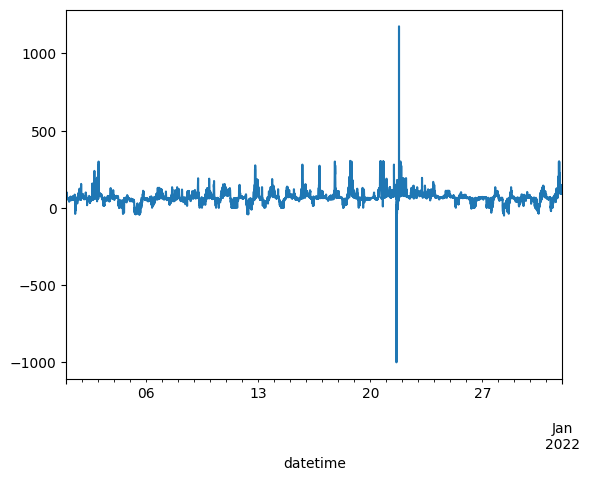

In [3]:
df = pd.read_parquet(Path.cwd().parent / "data")
df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
df = df.rename(columns={"SETTLEMENTDATE": "datetime", "RRP": "energy_price"})
df = df.query("INTERVENTION==0 and REGIONID=='NSW1'")
nsw_energy_price = df.set_index("datetime")["energy_price"]
nsw_energy_price.plot()

## Formulating the problem

Our mixed-integer linear program (MILP) formulation has one binary variable:

\begin{aligned}
\max_{t} \quad & \sum_{t=0}^T{\tau\lambda_t(p_t-q_t)}\\
\textrm{s.t.} \quad & u_t \in \{0,1\}    \\
& 0 \leq p_t \leq \bar{p}\\
& 0 \leq q_t \leq \bar{p} \\
& p_t - \bar{p}\left(1-u_t\right) \leq 0\\
& q_t - \bar{p}u_t \leq 0\\
& \underline{e} \leq e_t \leq \bar{e}    \\
& e_t-e_{t-1}- \left( q_t\eta_{charge}\tau\right)+\frac{p_t\tau}{\eta_{discharge}} = 0\\
& e_0 = 0.5\bar{e}\\
\end{aligned}

where:
- $\tau=\frac{1}{12} \textrm{hours}$
- $p_t$ corresponds to MW discharge at time $t$
- $q_t$ corresponds to MW charge at time $t$
- $u_t=1$ indicates charging, $u_t=0$ indicates discharging (*charge state*)
- $\bar{p}$ corresponds to the max power capacity in MW
- $\underline{e}$ and $\bar{e}$ corresponds to minimum and maximum state-of-charge limits, respectively
- $\lambda_t$ corresponds to the energy price in $/MWh at time $t$
- $\eta$ corresponds to efficiency (one term for charging and one term for discharging)

In [4]:
def create_mip_model(nsw_energy_price: pd.DataFrame, solver: str, verbose=1):
    power_cap = 30.0  # MW
    energy_cap = 30.0  # MWh
    soc_lower_limit = 0.1 * energy_cap  # MWh
    soc_upper_limit = 0.9 * energy_cap  # MWh
    charge_eff = 0.9  # unitless
    discharge_eff = 0.9  # unitless
    tau = 5.0 / 60.0  # minutes per hour
    # initial conditions
    initial_soc_mwh = 0.5 * energy_cap  # MWh

    m = Model(sense=MAXIMIZE, solver_name=solver)
    m.verbose = verbose
    # variables
    discharge_mw = [
        m.add_var(name=f"discharge_mw[{i}]", lb=0.0, ub=power_cap)
        for i in range(len(nsw_energy_price))
    ]
    charge_mw = [
        m.add_var(name=f"charge_mw[{i}]", lb=0.0, ub=power_cap)
        for i in range(len(nsw_energy_price))
    ]
    charge_state = [
        m.add_var(name=f"charge_state[{i}]", var_type=BINARY)
        for i in range(len(nsw_energy_price))
    ]
    soc_mwh = [
        m.add_var(name=f"soc_mwh[{i}]", lb=soc_lower_limit, ub=soc_upper_limit)
        for i in range(len(nsw_energy_price))
    ]

    # state of operation constraints
    for t in range(len(nsw_energy_price)):
        m += (
            discharge_mw[t] - power_cap * (1 - charge_state[t]) <= 0.0,
            f"discharging-operation[{t}]",
        )
        m += (
            charge_mw[t] - power_cap * charge_state[t] <= 0.0,
            f"charging-operation[{t}]",
        )

    # intertemporal energy balance constraints
    for t in range(1, len(nsw_energy_price)):
        m += (
            soc_mwh[t]
            - soc_mwh[t - 1]
            - charge_mw[t] * charge_eff * tau
            + discharge_mw[t] / discharge_eff * tau
            == 0.0,
            f"intertemp_soc[{t}]",
        )
    # initial SoC constraint
    m += soc_mwh[0] == 0.5 * energy_cap
    # objective - add negative sign as linopy only permits minimisation
    m.objective = xsum(
        nsw_energy_price[t] * tau * (discharge_mw[t] - charge_mw[t])
        for t in range(len(nsw_energy_price))
    )
    m.optimize()
    return m

In [5]:
model = create_mip_model(nsw_energy_price, GUROBI)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 26784 rows, 35712 columns and 71421 nonzeros
Model fingerprint: 0xcbbd520e
Variable types: 26784 continuous, 8928 integer (8928 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+01]
  Objective range  [8e-07, 1e+02]
  Bounds range     [1e+00, 3e+01]
  RHS range        [2e+01, 3e+01]
Found heuristic solution: objective 988.7050230
Presolve removed 6 rows and 7 columns
Presolve time: 0.06s
Presolved: 26778 rows, 35705 columns, 71409 nonzeros
Variable types: 26778 continuous, 8927 integer (8927 binary)

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Sh

In [6]:
cbc_model = create_mip_model(nsw_energy_price, CBC)

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Dual Simplex

Coin0506I Presolve 26777 (-7) rows, 35703 (-9) columns and 71406 (-15) elements
Clp0014I Perturbing problem by 0.001% of 0.2875244 - largest nonzero change 0.00010028454 ( 1180.479%) - largest zero change 5.014186e-05
Clp0000I Optimal - objective value 171902.29
Coin0511I After Postsolve, objective 171902.29, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 171902.2858 - 12913 iterations time 0.222, Presolve 0.04

Starting MIP optimization
Cgl0004I processed model has 26777 rows, 35703 columns (8927 integer (8927 of which binary)) and 71406 elements
Coin3009W Conflict graph built in 0.005 seconds, density: 0.000%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I Nauty sparseSpace 552374 affine 62310 coefficient count 124791
Cbc0045I Nauty: 124780 orbits (3 useful covering 6 variables), 

## Benchmarking

In [7]:
t_g = timeit.timeit(
    lambda: create_mip_model(nsw_energy_price, GUROBI, verbose=0), number=10
)
print(t_g / 10)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-09
1.6041008333995705


In [8]:
t_cbc = timeit.timeit(
    lambda: create_mip_model(nsw_energy_price, CBC, verbose=0), number=10
)
print(t_cbc / 10)

10.111563905701042


## Solution

In [9]:
if model.status == OptimizationStatus.OPTIMAL:
    print("gurobi optimal solution cost {} found".format(model.objective_value))
    print("cbc optimal solution cost {} found".format(cbc_model.objective_value))

gurobi optimal solution cost 171880.66124949063 found
cbc optimal solution cost 171886.98462167615 found


In [10]:
charge_mw = []
discharge_mw = []
charge_state = []
for t in range(len(nsw_energy_price)):
    charge_mw.append(model.var_by_name(f"charge_mw[{t}]").x)
    discharge_mw.append(model.var_by_name(f"discharge_mw[{t}]").x)
    charge_state.append(model.var_by_name(f"charge_state[{t}]").x)

In [11]:
soln = pd.DataFrame(
    {
        "charge_mw": charge_mw,
        "discharge_mw": discharge_mw,
        "charge_state": charge_state,
    },
    index=nsw_energy_price.index,
)

In [12]:
soln.loc[(soln["charge_mw"] > 0) & (soln["discharge_mw"] > 0)]

,charge_mw,discharge_mw,charge_state
datetime,,,


Text(0, 0.5, 'MW')

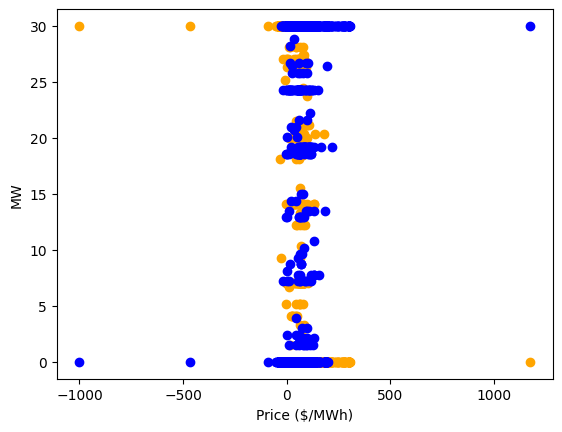

In [13]:
p = plt.scatter(nsw_energy_price, soln["charge_mw"], color="orange")
plt.scatter(nsw_energy_price, soln["discharge_mw"], color="blue")
plt.xlabel("Price ($/MWh)")
plt.ylabel("MW")

Text(0, 0.5, 'charge state')

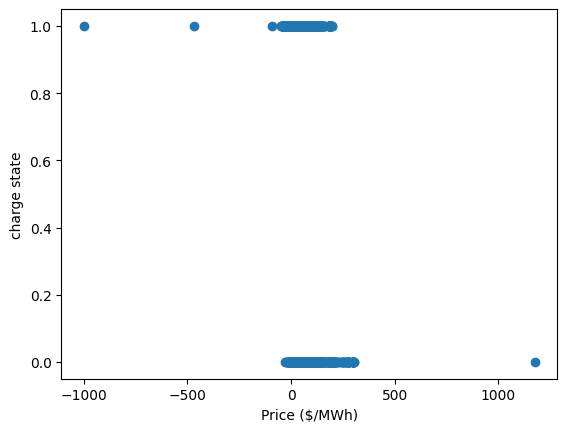

In [14]:
plt.scatter(nsw_energy_price, soln["charge_state"])
plt.xlabel("Price ($/MWh)")
plt.ylabel("charge state")